In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])
import torchmetrics

from tqdm.auto import tqdm
from typing import Tuple, Set, List, Union, Dict

import io
from PIL import Image
import IPython.display as disp

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

In [2]:
device               = params.device
ticker               = params.ticker
save_path            = params.save_path

Model selected: dfs_training/AAPL_0.1824.pth 

{'ATT_DROPOUT': 0.1,
 'ATT_HEADS': 8,
 'CLIPNORM': 1.0,
 'CLS_LOSS_WEIGHT': 5.0,
 'DROPOUT_LONG': 0.2,
 'DROPOUT_SHORT': 0.15,
 'EARLY_STOP_PATIENCE': 5,
 'ETA_MIN': 1e-05,
 'HUBER_BETA': 0.3,
 'INITIAL_LR': 0.001,
 'LONG_UNITS': 128,
 'LR_EPOCHS_WARMUP': 3,
 'MAX_EPOCHS': 60,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 2,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 64,
 'TERNARY_LOSS_WEIGHT': 3.0,
 'TRAIN_BATCH': 32,
 'TRAIN_PREFETCH_FACTOR': 1,
 'T_0': 90,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 0.0001}


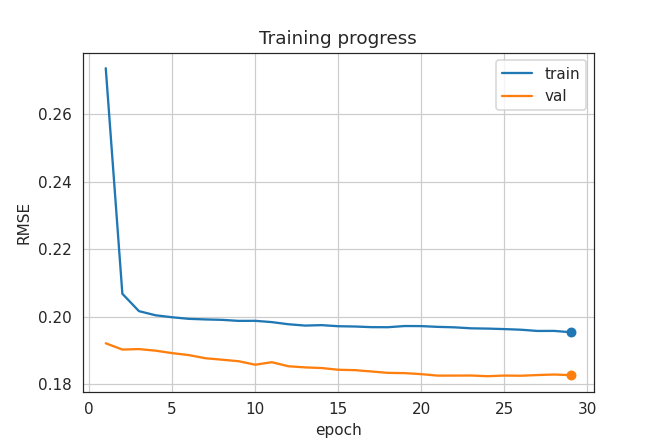


Train metrics: {'rmse': 0.19539296627044678, 'mae': 0.13843953609466553, 'r2': 0.23864448070526123, 'acc': 0.820763349533081, 'prec': 0.6088358759880066, 'rec': 0.22673732042312622, 'f1': 0.3304218351840973, 'auroc': 0.7892709970474243, 't_acc': 0.36331906914711, 't_prec': 0.5395793318748474, 't_rec': 0.36331906914711, 't_f1': 0.36032646894454956, 't_auc': 0.569861114025116}
Val metrics: {'rmse': 0.18266943097114563, 'mae': 0.13154201209545135, 'r2': 0.27329814434051514, 'acc': 0.830769419670105, 'prec': 0.6373065710067749, 'rec': 0.24615409970283508, 'f1': 0.355138897895813, 'auroc': 0.7982925772666931, 't_acc': 0.36230969429016113, 't_prec': 0.5802791714668274, 't_rec': 0.36230969429016113, 't_f1': 0.3633488118648529, 't_auc': 0.5911712050437927} 



DualMemoryLSTM(
  (conv): Conv1d(15, 15, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(15, 32, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (do_short): Dropout(p=0.15, inplace=False)
  (ln_short): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.2, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
  (cls_ter): Linear(in_features=128, out_features=3, bias=True)
)

In [3]:
model_path = min(
    save_path.glob(f"{ticker}_*.pth"),
    key=lambda p: float(p.stem.split("_")[-1])
)
print('Model selected:', model_path,'\n')

# Load the entire model object (architecture + weights)# 1) load your checkpoint dict
ckpt = torch.load(model_path, map_location=device, weights_only=False)

# 2) grab the full model object you saved
model_best = ckpt["model_obj"]

# 3) move to device and set eval mode
model_best = model_best.to(device).eval()

# 4) show parameters, training plot, and model
saved_hparams = ckpt["hparams"]
pprint(saved_hparams)

png_bytes = ckpt.get("train_plot_png")
img = Image.open(io.BytesIO(png_bytes))
disp.display(img)

print('\nTrain metrics:', ckpt.get("train_metrics"))
print('Val metrics:', ckpt.get("val_metrics"),'\n')

model_best


In [4]:
df_feat = pd.read_csv(params.feat_csv, index_col=0, parse_dates=True)
df_feat

,open,high,low,close,volume,atr_14,ma_5,ma_20,ma_diff,macd_12_26,...,bb_width_20,stoch_k_14,stoch_d_3,in_trading,hour,day_of_week,month,bid,ask,signal
2004-01-02 13:09:00,-0.193147,-0.317313,-0.028125,-0.193762,-0.319224,-1.435516,-0.185561,-0.282361,0.123688,0.202706,...,-0.929333,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763664,0.764807,0.005593
2004-01-02 13:10:00,-0.201085,-0.324262,-0.037500,-0.201725,-0.283773,-1.432540,-0.192087,-0.284115,0.112444,0.193448,...,-0.921566,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763647,0.764790,0.006095
2004-01-02 13:11:00,-0.209022,-0.331210,-0.046875,-0.209688,-0.248322,-1.429563,-0.200245,-0.286307,0.098388,0.183174,...,-0.913246,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763631,0.764773,0.006642
2004-01-02 13:12:00,-0.216960,-0.338159,-0.056250,-0.217651,-0.212872,-1.426587,-0.208402,-0.288939,0.085270,0.172220,...,-0.904541,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763614,0.764757,0.007239
2004-01-02 13:13:00,-0.224897,-0.345107,-0.065625,-0.225614,-0.177421,-1.423611,-0.216560,-0.292008,0.073088,0.160859,...,-0.895592,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763597,0.764740,0.007889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.475806,0.704918,0.500000,0.705997,5.467381,2.024482,0.367023,-0.130453,2.191746,1.957857,...,0.122381,0.619888,0.342752,1,-0.939,0.039,0.146,196.667400,196.962600,0.000000
2025-06-18 20:57:00,0.685484,0.836066,0.387097,0.478780,6.628840,2.207440,0.460866,-0.093452,2.466615,1.999189,...,0.187641,0.223810,0.415204,1,-0.939,0.039,0.146,196.527500,196.822500,0.000000
2025-06-18 20:58:00,0.467742,0.508197,0.500000,0.470665,7.630343,2.216153,0.497086,-0.060109,2.478653,2.004989,...,0.241322,0.209943,0.370103,1,-0.939,0.039,0.146,196.522500,196.817500,0.000000
2025-06-18 20:59:00,0.475806,0.524590,-0.129032,-0.227217,31.658646,2.487280,0.408182,-0.062549,2.057321,1.614144,...,0.245429,-0.982637,-0.192907,1,-0.939,0.039,0.146,196.092800,196.387200,0.043551


In [5]:
# 1) build the mem-mapped windows **and** get the end-of-window stamps
print('executing <build_lstm_tensors>...')
X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
    df            = df_feat,
    look_back     = params.look_back_tick,
    features_cols = params.features_cols_tick,
    label_col     = params.label_col,
    return_col    = params.return_col,
    sess_start    = params.sess_start_pred_tick 
)


# 2) split by day USING your end_times array, not df_feat
print('executing <chronological_split>...')
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models.chronological_split(
    X, y_sig, y_ret,
    raw_close, raw_bid, raw_ask,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # train split:   
    X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,           y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,            y_sig_te,     y_ret_te,   end_times_te,
    raw_close_te, raw_bid_te, raw_ask_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

# how many calendar-days in each split?
print("Days →",
      f"train={len(train_loader.dataset)},",
      f"val={len(val_loader.dataset)},",
      f"test={len(test_loader.dataset)}")

# how many sliding-windows in each split?
print("Windows →",
      f"train={train_loader.dataset.X.shape[0]},",
      f"val={val_loader.dataset.X.shape[0]},",
      f"test={test_loader.dataset.X.shape[0]}")

# how many batches per loader?
print("Batches →",
      f"train={len(train_loader)},",
      f"val={len(val_loader)},",
      f"test={len(test_loader)}")

executing <build_lstm_tensors>...


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

executing <chronological_split>...
executing <split_to_day_datasets>...
Days → train=3808, val=783, test=809
Windows → train=1600443, val=329639, test=340421
Batches → train=119, val=783, test=809


In [6]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(val_loader)
test_baseline = models.naive_rmse(test_loader)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.28600
Test zero‐forecast baseline RMSE = 0.27331


std val: 0.21428323
std test: 0.20394681


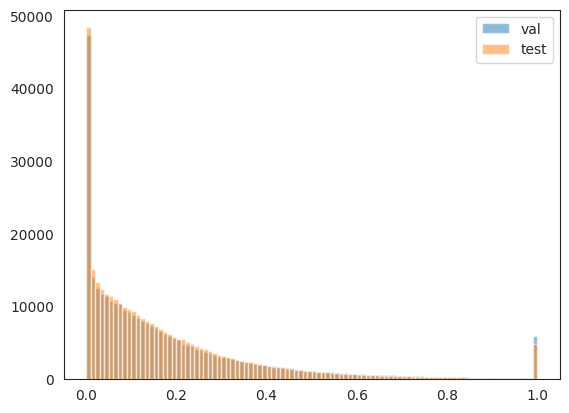

In [7]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in val_loader])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in test_loader])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [8]:
def evaluate_model(model, loader, device, split_name: str):
    """
    Evaluate a trained Stateful CNN→BiLSTM→Attention→BiLSTM model on a DataLoader.

    Steps:
      1) model.eval(), reset LSTM states.
      2) Instantiate regression, binary, and ternary torchmetrics.
      3) Loop over padded batches:
         - Unpack sequences (with or without raw prices).
         - For each calendar-day in batch:
             • Slice to true length, reset states on day rollover.
             • Forward pass → (raw_reg, raw_bin, raw_ter).
             • Compute sigmoid/softmax → binary & multiclass probs.
             • Update all metrics on unpadded windows.
      4) Compute final metrics, print them in the format:
         R: … | B: … | T: …
      5) Return (metrics_dict, concatenated regression preds).
    """
    # 1) Prepare model
    model.to(device).eval() # it should provide the same validation metrics, but slightly higher training metrics, than the metrics during model training (printed above)
    model.h_short = model.h_long = None

    # 2) Metrics setup
    thr = 0.5
    rmse_m      = torchmetrics.MeanSquaredError(squared=False).to(device)
    mae_m       = torchmetrics.MeanAbsoluteError().to(device)
    r2_m        = torchmetrics.R2Score().to(device)
    
    acc_m       = torchmetrics.classification.BinaryAccuracy(threshold=thr).to(device)
    prec_m      = torchmetrics.classification.BinaryPrecision(threshold=thr).to(device)
    rec_m       = torchmetrics.classification.BinaryRecall(threshold=thr).to(device)
    f1_m        = torchmetrics.classification.BinaryF1Score(threshold=thr).to(device)
    auc_m       = torchmetrics.classification.BinaryAUROC().to(device)

    ter_acc_m   = torchmetrics.classification.MulticlassAccuracy(num_classes=3).to(device)
    ter_prec_m  = torchmetrics.classification.MulticlassPrecision(num_classes=3, average="macro").to(device)
    ter_rec_m   = torchmetrics.classification.MulticlassRecall(num_classes=3, average="macro").to(device)
    ter_f1_m    = torchmetrics.classification.MulticlassF1Score(num_classes=3, average="macro").to(device)
    ter_auc_m   = torchmetrics.classification.MulticlassAUROC(num_classes=3, average="macro").to(device)

    for m in (rmse_m, mae_m, r2_m,
              acc_m, prec_m, rec_m, f1_m, auc_m,
              ter_acc_m, ter_prec_m, ter_rec_m, ter_f1_m, ter_auc_m):
        m.reset()

    all_preds = []
    prev_day  = None

    # 3) Loop through batches
    with torch.no_grad():
        for batch in tqdm(loader, desc=split_name, unit="batch"):
            # unpack depending on raw-price presence
            if len(batch) == 11:
                (xb, y_reg, y_bin, y_ret, y_ter, 
                 rc, rb, ra, wd, ts_list, lengths) = batch
            else:
                xb, y_reg, y_bin, y_ret, y_ter, wd, ts_list, lengths = batch

            # move tensors to device
            xb    = xb.to(device, non_blocking=True)
            y_reg = y_reg.to(device, non_blocking=True)
            y_bin = y_bin.to(device, non_blocking=True)
            y_ret = y_ret.to(device, non_blocking=True)
            y_ter = y_ter.to(device, non_blocking=True)
            wd    = wd.to(device, non_blocking=True)

            B = xb.size(0)
            for i in range(B):
                W_true = lengths[i]
                day_id = int(wd[i].item())

                # reset or carry LSTM states
                model.reset_short()
                if prev_day is not None and day_id < prev_day:
                    model.reset_long()
                prev_day = day_id

                # slice to true window length
                x_day = xb[i, :W_true]
                y_day = y_reg[i, :W_true].view(-1)
                bin_t = y_bin[i, :W_true].view(-1)
                ter_t = y_ter[i, :W_true].view(-1)

                # forward
                raw_reg, raw_bin, raw_ter = model(x_day)
                pr  = raw_reg[..., -1, 0]    # (W_true,)
                pb  = raw_bin[..., -1, 0]
                pt  = raw_ter[..., -1, :]    # (W_true, 3)

                # probabilities
                prob_b = torch.sigmoid(pb)
                prob_t = torch.softmax(pt, dim=-1)

                # update metrics
                rmse_m.update(pr, y_day)
                mae_m .update(pr, y_day)
                r2_m  .update(pr, y_day)

                acc_m .update(prob_b, bin_t)
                prec_m.update(prob_b, bin_t)
                rec_m .update(prob_b, bin_t)
                f1_m  .update(prob_b, bin_t)
                auc_m .update(prob_b, bin_t)

                ter_acc_m .update(prob_t, ter_t)
                ter_prec_m.update(prob_t, ter_t)
                ter_rec_m .update(prob_t, ter_t)
                ter_f1_m  .update(prob_t, ter_t)
                ter_auc_m .update(prob_t, ter_t)

                all_preds.append(pr.cpu().numpy())

    # 4) Compute final metrics
    metrics = {
        "rmse":   rmse_m.compute().item(),
        "mae":    mae_m.compute().item(),
        "r2":     r2_m.compute().item(),
        "acc":    acc_m.compute().item(),
        "prec":   prec_m.compute().item(),
        "rec":    rec_m.compute().item(),
        "f1":     f1_m.compute().item(),
        "auroc":  auc_m.compute().item(),
        "t_acc":  ter_acc_m.compute().item(),
        "t_prec": ter_prec_m.compute().item(),
        "t_rec":  ter_rec_m.compute().item(),
        "t_f1":   ter_f1_m.compute().item(),
        "t_auc":  ter_auc_m.compute().item()
    }

    # 5) Print in the desired format
    print(
        f"{split_name}→ "
        f'"R": RMSE={metrics["rmse"]:.5f} MAE={metrics["mae"]:.5f} R2={metrics["r2"]:.4f} | '
        f'"B": Acc={metrics["acc"]:.4f} Prec={metrics["prec"]:.4f} Rec={metrics["rec"]:.4f} '
           f'F1={metrics["f1"]:.4f} AUROC={metrics["auroc"]:.4f} | '
        f'"T": Acc={metrics["t_acc"]:.4f} Prec={metrics["t_prec"]:.4f} Rec={metrics["t_rec"]:.4f} '
           f'F1={metrics["t_f1"]:.4f} AUROC={metrics["t_auc"]:.4f}'
    )

    return metrics, np.concatenate(all_preds, axis=0)


In [9]:
# Run evaluation on all three splits
train_metrics, train_preds = evaluate_model(
    model_best, train_loader, device, split_name="TRAIN"
)
val_metrics, val_preds     = evaluate_model(
    model_best, val_loader,   device, split_name="VALID"
)
test_metrics, test_preds   = evaluate_model(
    model_best, test_loader,  device, split_name="TEST"
)

print("\nPredictions lengths:")
print(f"  Train: {len(train_preds)}")
print(f"  Valid: {len(val_preds)}")
print(f"  Test : {len(test_preds)}")


TRAIN:   0%|          | 0/119 [00:00<?, ?batch/s]

TRAIN→ "R": RMSE=0.19454 MAE=0.14133 R2=0.2453 | "B": Acc=0.8210 Prec=0.5881 Rec=0.2750 F1=0.3748 AUROC=0.7932 | "T": Acc=0.3628 Prec=0.5856 Rec=0.3628 F1=0.3541 AUROC=0.5743


VALID:   0%|          | 0/783 [00:00<?, ?batch/s]

VALID→ "R": RMSE=0.18267 MAE=0.13154 R2=0.2733 | "B": Acc=0.8308 Prec=0.6373 Rec=0.2462 F1=0.3551 AUROC=0.7983 | "T": Acc=0.3623 Prec=0.5803 Rec=0.3623 F1=0.3633 AUROC=0.5912


TEST:   0%|          | 0/809 [00:00<?, ?batch/s]

TEST→ "R": RMSE=0.18010 MAE=0.13050 R2=0.2202 | "B": Acc=0.8367 Prec=0.6124 Rec=0.1911 F1=0.2913 AUROC=0.7653 | "T": Acc=0.3491 Prec=0.3398 Rec=0.3491 F1=0.3400 AUROC=0.5613

Predictions lengths:
  Train: 1600443
  Valid: 329639
  Test : 340421


In [10]:
# Train metrics: {'rmse': 0.19539296627044678, 'mae': 0.13843953609466553, 'r2': 0.23864448070526123, 'acc': 0.820763349533081, 'prec': 0.6088358759880066, 'rec': 0.22673732042312622, 'f1': 0.3304218351840973, 'auroc': 0.7892709970474243, 't_acc': 0.36331906914711, 't_prec': 0.5395793318748474, 't_rec': 0.36331906914711, 't_f1': 0.36032646894454956, 't_auc': 0.569861114025116}
# Val metrics: {'rmse': 0.18266943097114563, 'mae': 0.13154201209545135, 'r2': 0.27329814434051514, 'acc': 0.830769419670105, 'prec': 0.6373065710067749, 'rec': 0.24615409970283508, 'f1': 0.355138897895813, 'auroc': 0.7982925772666931, 't_acc': 0.36230969429016113, 't_prec': 0.5802791714668274, 't_rec': 0.36230969429016113, 't_f1': 0.3633488118648529, 't_auc': 0.5911712050437927} 

In [11]:
def add_pred_and_split(
    df: pd.DataFrame,
    train_preds: np.ndarray,
    val_preds:   np.ndarray,
    test_preds:  np.ndarray,
    end_times_tr:  np.ndarray,    # shape (N_train,)
    end_times_val: np.ndarray,    # shape (N_val,)
    end_times_te:  np.ndarray     # shape (N_test,)
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Stamp each window’s prediction back onto the exact bar
    that was its end‐of‐window, then split into train+val vs test.

    1) Copy df, add columns pred_signal & pred_action.
    2) Build three pd.Series of preds indexed by their end_times.
    3) Assign them into df2.loc[idx, 'pred_signal'].
    4) Derive pred_action = (pred_signal > 0).
    5) Extract df_trainval and df_test by selecting only rows
       where pred_signal is notna for each split.
    """
    df2 = df.copy()
    df2["pred_signal"] = np.nan
    df2["pred_action"] = 0

    # 1) original size
    print(f"🔍 Original DataFrame has {len(df2)} rows")

    # 2) how many days in each split
    tr_days = pd.DatetimeIndex(end_times_tr).normalize().unique()
    vl_days = pd.DatetimeIndex(end_times_val).normalize().unique()
    te_days = pd.DatetimeIndex(end_times_te).normalize().unique()
    print(f"• Train days: {len(tr_days)} | Val days: {len(vl_days)} | Test days: {len(te_days)}")

    # 3) bar‐count notice
    print("✓ Computed per‐day bar counts (cnt) for look_back filtering")

    # 4) total window‐ends seen
    total_end = len(end_times_tr) + len(end_times_val) + len(end_times_te)
    print(f"⏹ Found {total_end} window‐end bars after time & look_back filter")

    # 5) index counts
    print(
        f"  – Train idx: {len(end_times_tr)} | "
        f"Val idx: {len(end_times_val)} | "
        f"Test idx: {len(end_times_te)}"
    )

    # 6) build pd.Series & stamp
    s_tr  = pd.Series(train_preds, index=pd.DatetimeIndex(end_times_tr))
    s_val = pd.Series(val_preds,   index=pd.DatetimeIndex(end_times_val))
    s_te  = pd.Series(test_preds,  index=pd.DatetimeIndex(end_times_te))

    df2.loc[s_tr.index,  "pred_signal"] = s_tr.values
    df2.loc[s_val.index, "pred_signal"] = s_val.values
    df2.loc[s_te.index,  "pred_signal"] = s_te.values

    # 7) check exact matches
    print(f"✅ Train preds match window‐ends exactly ({len(train_preds)})")
    print(f"✅ Val preds match window‐ends exactly   ({len(val_preds)})")
    print(f"✅ Test preds match window‐ends exactly  ({len(test_preds)})")

    # 8) finalize
    print("🎯 Stamped all predictions into 'pred_signal' column")
    df2["pred_action"] = (df2["pred_signal"] > 0).astype(int)

    df_trainval = df2.loc[s_tr.index.union(s_val.index)].dropna(subset=["pred_signal"])
    df_test     = df2.loc[s_te.index].dropna(subset=["pred_signal"])

    print("🏁 Finished. Returning filtered DataFrames (no NaNs in pred_signal).")
    return df_trainval, df_test

In [12]:
df_trainval, df_test = add_pred_and_split(
    df             = df_feat,
    train_preds    = train_preds,
    val_preds      = val_preds,
    test_preds     = test_preds,
    end_times_tr   = end_times_tr,
    end_times_val  = end_times_val,
    end_times_te   = end_times_te
)

print('saving the test csv...')
df_test.to_csv(params.test_csv)
print('saving the train&val csv...')
df_trainval.to_csv(params.trainval_csv)

df_trainval

🔍 Original DataFrame has 3601230 rows
• Train days: 3808 | Val days: 783 | Test days: 809
✓ Computed per‐day bar counts (cnt) for look_back filtering
⏹ Found 2270503 window‐end bars after time & look_back filter
  – Train idx: 1600443 | Val idx: 329639 | Test idx: 340421
✅ Train preds match window‐ends exactly (1600443)
✅ Val preds match window‐ends exactly   (329639)
✅ Test preds match window‐ends exactly  (340421)
🎯 Stamped all predictions into 'pred_signal' column
🏁 Finished. Returning filtered DataFrames (no NaNs in pred_signal).
saving the test csv...
saving the train&val csv...


,open,high,low,close,volume,atr_14,ma_5,ma_20,ma_diff,macd_12_26,...,stoch_d_3,in_trading,hour,day_of_week,month,bid,ask,signal,pred_signal,pred_action
2004-01-02 14:00:00,-0.597963,-0.671685,-0.506250,-0.599867,1.488767,-1.402778,-0.599973,-0.670029,-1.242828e-13,-0.063516,...,-1.561625,0,0.247,-0.976,0.351,0.762810,0.763953,0.448429,0.122643,1
2004-01-02 14:01:00,-0.605900,-0.678633,-0.515625,-0.607830,1.524218,-1.402778,-0.608131,-0.678800,0.000000e+00,-0.064115,...,-1.561625,0,0.247,-0.976,0.351,0.762794,0.763936,0.488664,0.127585,1
2004-01-02 14:02:00,-0.613838,-0.685582,-0.525000,-0.615793,1.559669,-1.402778,-0.616288,-0.687570,0.000000e+00,-0.064671,...,-1.561625,0,0.247,-0.976,0.351,0.762777,0.763920,0.532508,0.132215,1
2004-01-02 14:03:00,-0.621775,-0.692530,-0.534375,-0.623756,1.595119,-1.402778,-0.624446,-0.696341,-1.242828e-13,-0.065186,...,-1.561625,0,0.247,-0.976,0.351,0.762760,0.763903,0.580285,0.136757,1
2004-01-02 14:04:00,-0.629713,-0.699479,-0.543750,-0.631719,1.630570,-1.402778,-0.632604,-0.705112,-1.242828e-13,-0.065663,...,-1.561625,0,0.247,-0.976,0.351,0.762743,0.763886,0.632348,0.142851,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28 20:56:00,0.736230,0.747917,0.784043,0.790310,2.263197,0.652514,0.741828,0.738415,2.744130e-01,0.321477,...,1.211724,1,-0.939,0.973,0.979,175.238500,175.501500,0.318801,0.150765,1
2022-03-28 20:57:00,0.786714,0.797917,0.841489,0.822932,3.136585,0.765180,0.784641,0.743795,7.438394e-01,0.520116,...,1.289475,1,-0.939,0.973,0.979,175.316000,175.579200,0.224585,0.155495,1
2022-03-28 20:58:00,0.824577,0.839583,0.881915,0.880694,3.910116,0.836338,0.825969,0.753591,1.139913e+00,0.770887,...,1.438055,1,-0.939,0.973,0.979,175.453300,175.716700,0.008583,0.158473,1
2022-03-28 20:59:00,0.881372,0.897917,0.911702,0.882796,9.226442,0.943074,0.855498,0.762535,1.398787e+00,0.960884,...,1.284055,1,-0.939,0.973,0.979,175.458300,175.721700,0.000000,0.164126,1


In [13]:
# Compute Descriptive Statistics
# Statistics show whether your model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_test[['signal','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_test['signal'].corr(df_test['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

stats

,count,mean,std,min,25%,50%,75%,max,range,pearson_r_with_other
signal,340421.0,0.181938,0.203947,0.000000,0.036463,0.117839,0.251021,1.000000,1.00000,0.470588
pred_signal,340421.0,0.179480,0.102866,-0.032409,0.113071,0.161304,0.214262,0.965541,0.99795,0.470588


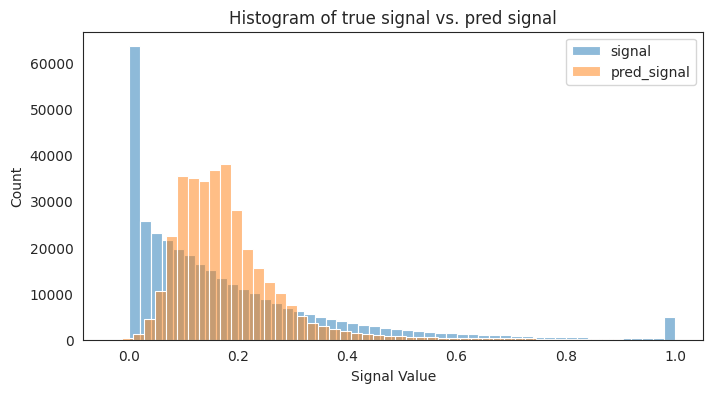

In [14]:
# Distribution Overlay
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_test['signal'], color='C0', alpha=0.5, bins=50, label='signal')
sns.histplot(df_test['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred_signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of true signal vs. pred signal')
plt.show()

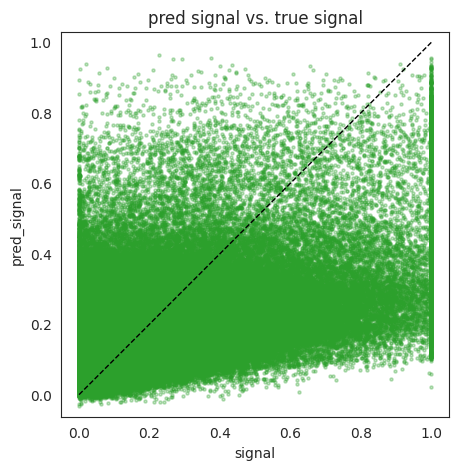

In [15]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_test['signal'], df_test['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal')
plt.ylabel('pred_signal')
plt.title('pred signal vs. true signal')
plt.axis('equal')
plt.show()

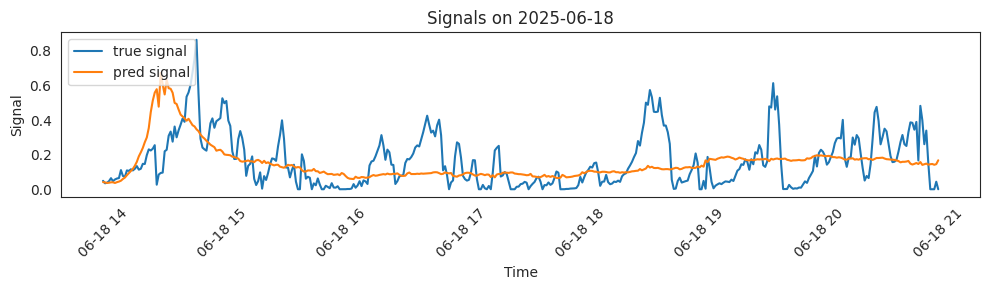

In [16]:
# Time-Series Comparison (Sample)
# Time‐series plots let you see if the model lags or leads the signal on a given day.

# pick a single day or time span
day = df_test.index.normalize().unique()[-1]
mask = df_test.index.normalize() == day

plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'signal'], label='true signal')
plt.plot(df_test.index[mask], df_test.loc[mask,'pred_signal'],   label='pred signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

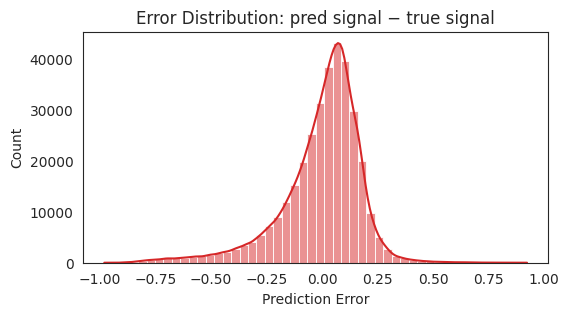

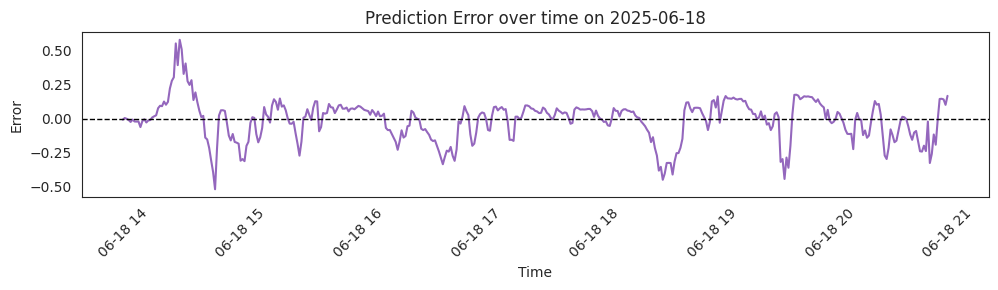

In [17]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding you to fix lag, amplitude scaling, or threshold issues.

# create error column
df_test['error'] = df_test['pred_signal'] - df_test['signal']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_test['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred signal − true signal')
plt.show()

# Time evolution of error on that same sample day
plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
# If running generate_trade_actions on a multi-day block, the in_trade flag won’t reset at midnight. Splitting by day below avoids that.

# how many unique days we’ll process
groups = list(df_test.groupby(df_test.index.normalize()))
n_days = len(groups)

sim_results = {}

for day, df_day in tqdm(groups, total=n_days, desc="Generate+Simulate"):
    # 1) Generate trade actions for this day
    df_actions = trades.generate_trade_actions(
        df=df_day,
        col_signal="pred_signal",
        col_action="pred_action",
        buy_threshold=params.pred_threshold_tick,
        trailing_stop_pct=params.trailing_stop_pred_tick,
        sess_start=params.sess_start
    )

    # 2) Simulate trading on this single‐day mini‐dict
    single_result = trades.simulate_trading(
        results_by_day_sign={day: (df_actions, [])},
        col_action="pred_action",
        sess_start=params.sess_start,
        sess_end=params.sess_end,
        ticker=ticker
    )

    # 3) Collect the output
    # single_result is { day: (df_sim, trades, stats) }
    sim_results.update(single_result)



Generate+Simulate:   0%|          | 0/809 [00:00<?, ?it/s]


Plotting days in 2024-06:



=== Performance for 2024-06-03 00:00:00 ===
Buy & Hold Return ($): 0.489
Strategy Return ($): -0.33
Trades Returns ($): [-0.331]



=== Performance for 2024-06-04 00:00:00 ===
Buy & Hold Return ($): -1.062
Strategy Return ($): -0.035
Trades Returns ($): [-0.035]



=== Performance for 2024-06-05 00:00:00 ===
Buy & Hold Return ($): -0.484
Strategy Return ($): -0.008
Trades Returns ($): [-0.008]



=== Performance for 2024-06-06 00:00:00 ===
Buy & Hold Return ($): -2.243
Strategy Return ($): -0.223
Trades Returns ($): [-0.223]



=== Performance for 2024-06-07 00:00:00 ===
Buy & Hold Return ($): 1.076
Strategy Return ($): -0.91
Trades Returns ($): [-0.577, -0.331]



=== Performance for 2024-06-10 00:00:00 ===
Buy & Hold Return ($): -4.293
Strategy Return ($): 0.184
Trades Returns ($): [-0.168, 0.192, 0.16]



=== Performance for 2024-06-11 00:00:00 ===
Buy & Hold Return ($): 12.544
Strategy Return ($): 9.506
Trades Returns ($): [9.886, -0.38]



=== Performance for 2024-06-12 00:00:00 ===
Buy & Hold Return ($): 5.249
Strategy Return ($): 1.659
Trades Returns ($): [7.758, -0.545, -0.073, -0.141, -0.625, -0.376, -0.616, 1.049, -4.772]



=== Performance for 2024-06-13 00:00:00 ===
Buy & Hold Return ($): -1.322
Strategy Return ($): 0.161
Trades Returns ($): [0.161]



=== Performance for 2024-06-14 00:00:00 ===
Buy & Hold Return ($): -1.9
Strategy Return ($): 0.0
Trades Returns ($): []



=== Performance for 2024-06-17 00:00:00 ===
Buy & Hold Return ($): 2.672
Strategy Return ($): 1.279
Trades Returns ($): [-0.92, -0.945, 2.818, -0.359, 0.355, -0.376, 0.706]



=== Performance for 2024-06-18 00:00:00 ===
Buy & Hold Return ($): -3.844
Strategy Return ($): 0.0
Trades Returns ($): []



=== Performance for 2024-06-20 00:00:00 ===
Buy & Hold Return ($): -4.428
Strategy Return ($): 0.0
Trades Returns ($): []



=== Performance for 2024-06-21 00:00:00 ===
Buy & Hold Return ($): -2.964
Strategy Return ($): 0.132
Trades Returns ($): [0.135, -0.002]



=== Performance for 2024-06-24 00:00:00 ===
Buy & Hold Return ($): 1.088
Strategy Return ($): 1.094
Trades Returns ($): [1.095]



=== Performance for 2024-06-25 00:00:00 ===
Buy & Hold Return ($): -0.975
Strategy Return ($): -0.0
Trades Returns ($): [-0.0]



=== Performance for 2024-06-26 00:00:00 ===
Buy & Hold Return ($): 1.446
Strategy Return ($): 0.447
Trades Returns ($): [0.083, 0.503, -0.138]



=== Performance for 2024-06-27 00:00:00 ===
Buy & Hold Return ($): -1.331
Strategy Return ($): -0.284
Trades Returns ($): [-0.283]



=== Performance for 2024-06-28 00:00:00 ===
Buy & Hold Return ($): -4.894
Strategy Return ($): -0.261
Trades Returns ($): [-0.262]

Overall Summary (2024-06-03 = 193.4650 → 2024-06-28 = 210.4620)

One-time buy&hold gain: 16.997
Buy & Hold – each day ($): -5.176
Strategy Return ($): 12.411
Trades Count: 37
Strategy return per trade: 0.335
Num. trading days: 19
Strategy return per trading day: 0.653


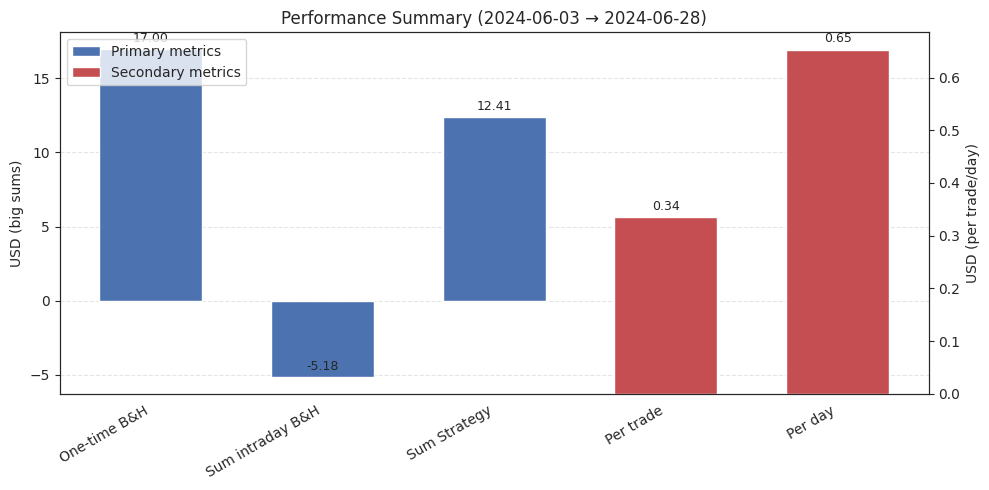


Overall Summary (2022-03-29 = 177.0727 → 2025-06-18 = 196.3926)

One-time buy&hold gain: 19.320
Buy & Hold – each day ($): -192.076
Strategy Return ($): -8.699
Trades Count: 1901
Strategy return per trade: -0.005
Num. trading days: 809
Strategy return per trading day: -0.011


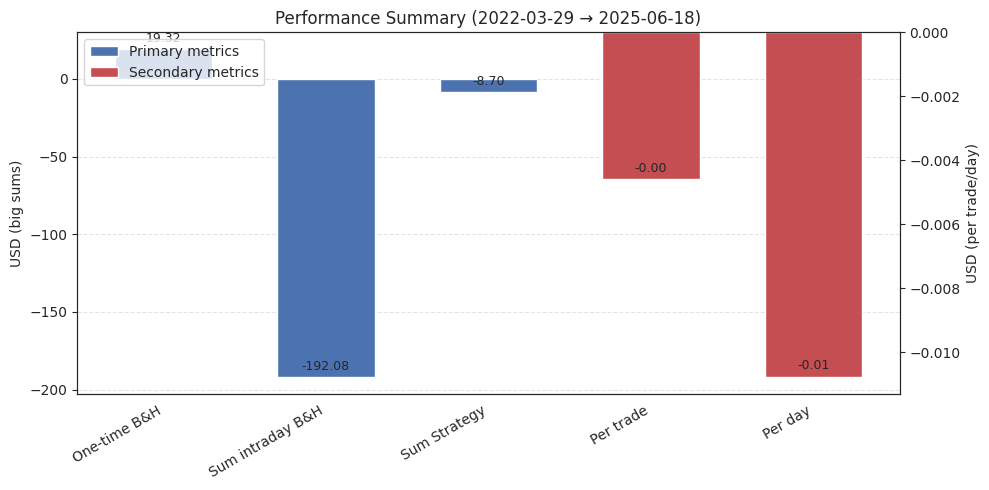

In [19]:
importlib.reload(params)
# month to inspect (YYYY-MM)
date_to_test = params.date_to_check

year, month = map(int, date_to_test.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_test}")
else:
    print(f"\nPlotting days in {date_to_test}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "signal",
            col_signal2       = "pred_signal",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_tick,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_test[df_test.index.to_period("M") == date_to_test]
plots.aggregate_performance(performance_month, df_month)

# 4) Overall summary across ALL days, with date range
plots.aggregate_performance(performance_all, df_test)